# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.172703,False,0.487212
1,-1.587366,False,-3.615591
2,0.748112,True,6.872637
3,1.091737,True,7.414136
4,-0.286934,True,3.681927
...,...,...,...
995,0.807835,True,6.409761
996,-1.148703,False,-1.696807
997,-0.367747,False,0.290330
998,0.477323,True,5.809864


<Axes: xlabel='v0'>

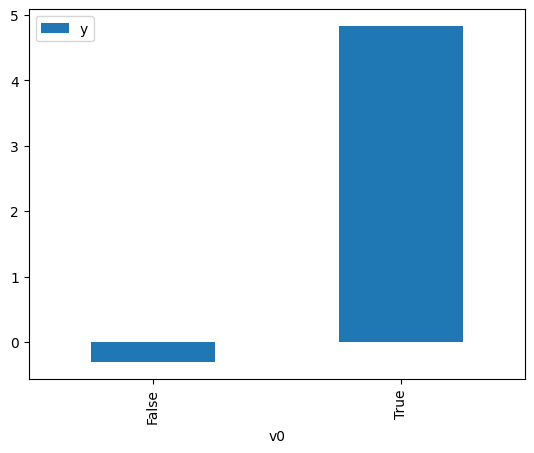

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

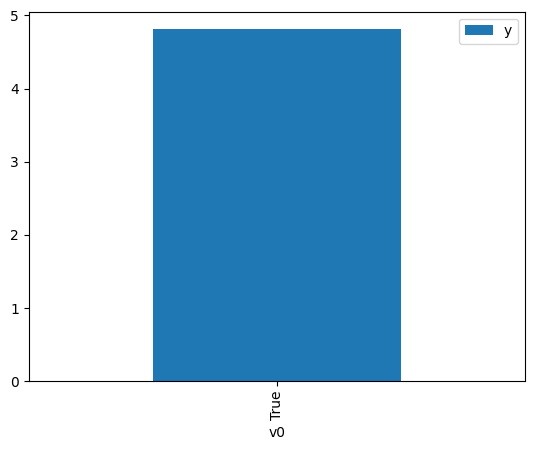

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.285716,False,-0.087360,0.399273,2.504554
1,-0.717493,False,-1.659798,0.753263,1.327558
2,0.636154,False,2.381278,0.280686,3.562700
3,0.915410,False,2.872034,0.203356,4.917485
4,1.912569,False,4.802676,0.053109,18.829258
...,...,...,...,...,...
995,0.427673,False,1.142105,0.348820,2.866808
996,-1.241196,False,-1.943783,0.871240,1.147790
997,0.984631,False,2.438371,0.186845,5.352040
998,0.177589,False,0.583466,0.439258,2.276568


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.319315,True,4.857947,0.612909,1.631563
1,0.260316,True,5.140960,0.591434,1.690806
2,-0.460619,True,4.454292,0.326136,3.066209
3,-1.477333,True,1.678653,0.093568,10.687403
4,-0.299012,True,6.674907,0.382224,2.616268
...,...,...,...,...,...
995,0.202220,True,3.413916,0.569940,1.754570
996,0.729354,True,5.825151,0.747004,1.338681
997,-0.613151,True,4.410444,0.277375,3.605228
998,-0.654808,True,3.494189,0.264866,3.775488


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              9626.
Date:                Sun, 03 Dec 2023   Prob (F-statistic):                        0.00
Time:                        07:56:53   Log-Likelihood:                         -1400.3
No. Observations:                1000   AIC:                                      2805.
Df Residuals:                     998   BIC:                                      2814.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6444      0.033     50.504      0.000       1.581       1.708
x2             5.0473      0.048    105.559      0.000       4.953       5.141
==============================================================================
Omnibus:                        0.625   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.732   Jarque-Bera (JB):                0.706
Skew:                          -0.048   Prob(JB):                        0.703
Kurtosis:                       2.912   Cond. No.                         1.68
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""